/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(



📊 Model Evaluation Metrics:
MAE: 20.67
RMSE: 28.8
R2: 0.9

📈 3-Day AQI Forecast:
        date       pm25        pm10         no2         o3  predicted_aqi
0 2023-12-03  97.014241  159.194502  117.776278  28.291677     212.110001
1 2023-12-04  97.110295  159.243328  117.979208  28.317358     212.110001
2 2023-12-05  97.206349  159.292153  118.182138  28.343040     212.110001


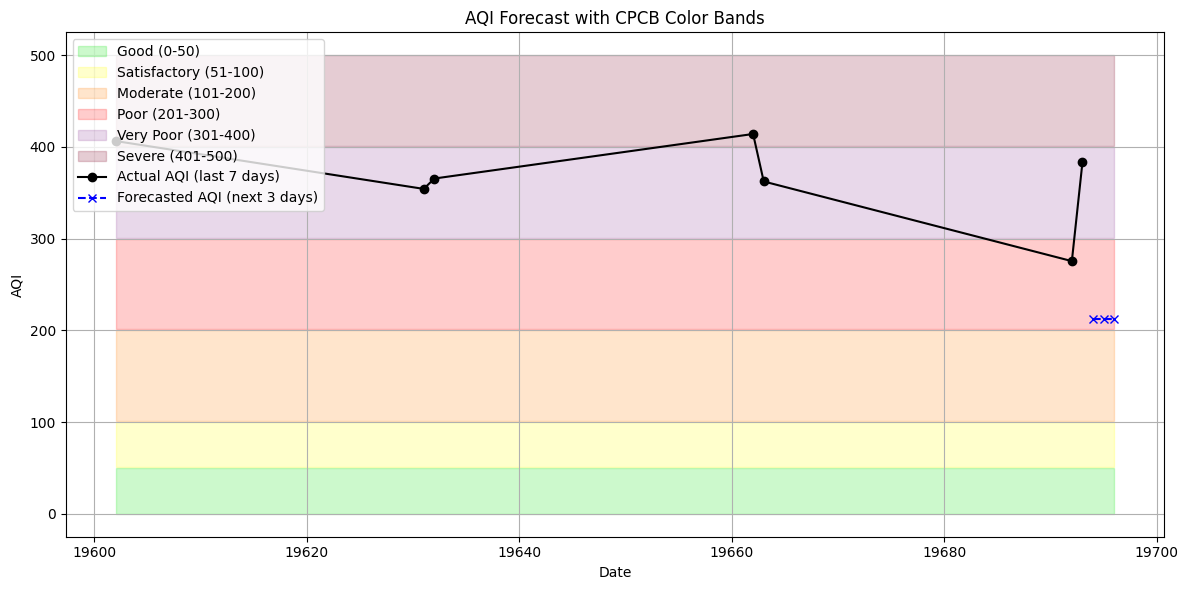

In [3]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# === 1. Load and Clean Data ===
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df = df.rename(columns={"from_date": "timestamp", "ozone": "o3", "pm2.5": "pm25"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
    df = df[["timestamp", "pm25", "pm10", "no2", "o3"]].dropna()
    return df

# === 2. AQI Calculation Logic ===
BREAKPOINTS = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
             (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 530, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 800, 401, 500)]
}

def calculate_sub_index(pollutant, value):
    for low, high, index_low, index_high in BREAKPOINTS.get(pollutant, []):
        if low <= value <= high:
            return ((index_high - index_low) / (high - low)) * (value - low) + index_low
    return None

def add_aqi_column(df):
    df["aqi"] = df.apply(lambda row: max(filter(None, [
        calculate_sub_index("pm25", row["pm25"]),
        calculate_sub_index("pm10", row["pm10"]),
        calculate_sub_index("no2", row["no2"]),
        calculate_sub_index("o3", row["o3"]),
    ])), axis=1)
    return df

# === 3. Train AQI Prediction Model ===
def train_model(df):
    df_daily = df.set_index("timestamp").resample("D").mean().dropna()
    X = df_daily[["pm25", "pm10", "no2", "o3"]]
    y = df_daily["aqi"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    metrics = {
        "MAE": round(mean_absolute_error(y_test, y_pred), 2),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred)), 2),
        "R2": round(r2_score(y_test, y_pred), 2)
    }
    return model, df_daily, metrics

# === 4. Forecast Pollutants ===
def forecast_pollutants(df_daily, days=1):
    future_data = pd.DataFrame()
    for pollutant in ["pm25", "pm10", "no2", "o3"]:
        df_temp = df_daily[[pollutant]].reset_index()
        df_temp["day"] = np.arange(len(df_temp))
        model = LinearRegression()
        model.fit(df_temp[["day"]], df_temp[pollutant])
        future_days = np.arange(len(df_temp), len(df_temp) + days).reshape(-1, 1)
        preds = model.predict(future_days)
        future_data[pollutant] = preds
    future_data["date"] = [df_daily.index[-1] + timedelta(days=i+1) for i in range(days)]
    return future_data.set_index("date")

# === 5. Predict AQI for Future Days ===
def predict_future_aqi(model, forecast_df):
    forecast_df["predicted_aqi"] = np.round(model.predict(forecast_df[["pm25", "pm10", "no2", "o3"]]), 2)
    return forecast_df.reset_index()

# === 6. Main Pipeline with Plot ===
def main():
    file_path = "BandraKurlaComplexMumbaiIITM.csv"  # Update with your CSV path
    df = load_and_clean_data(file_path)
    df = add_aqi_column(df)
    model, df_daily, metrics = train_model(df)
    forecast_df = forecast_pollutants(df_daily, days=3)
    prediction_df = predict_future_aqi(model, forecast_df)

    print("\n📊 Model Evaluation Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v}")

    print("\n📈 3-Day AQI Forecast:")
    print(prediction_df)

    # === Plot with AQI color bands ===
    last_actual = df_daily["aqi"].iloc[-7:]
    forecasted = prediction_df.set_index("date")["predicted_aqi"]
    all_dates = last_actual.index.tolist() + forecasted.index.tolist()
    all_values = last_actual.tolist() + forecasted.tolist()

    # AQI Categories
    aqi_categories = [
        ("Good", 0, 50, "#00e400"),
        ("Satisfactory", 51, 100, "#ffff00"),
        ("Moderate", 101, 200, "#ff7e00"),
        ("Poor", 201, 300, "#ff0000"),
        ("Very Poor", 301, 400, "#8f3f97"),
        ("Severe", 401, 500, "#7e0023"),
    ]

    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    # Add color bands
    for label, low, high, color in aqi_categories:
        ax.add_patch(Rectangle(
            (all_dates[0], low),
            all_dates[-1] - all_dates[0],
            high - low,
            color=color, alpha=0.2,
            label=f"{label} ({low}-{high})"
        ))

    # Plot AQI lines
    plt.plot(last_actual.index, last_actual.values, label="Actual AQI (last 7 days)", marker='o', color='black')
    plt.plot(forecasted.index, forecasted.values, label="Forecasted AQI (next 3 days)", marker='x', linestyle='--', color='blue')

    plt.title("AQI Forecast with CPCB Color Bands")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

# === Run Script ===
if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(



📈 Forecasted Pollutants and AQI for Next Day:
Date: 2023-12-03
PM2.5: 97.01, PM10: 159.19, NO2: 117.78, O3: 28.29
Predicted AQI: 221.52


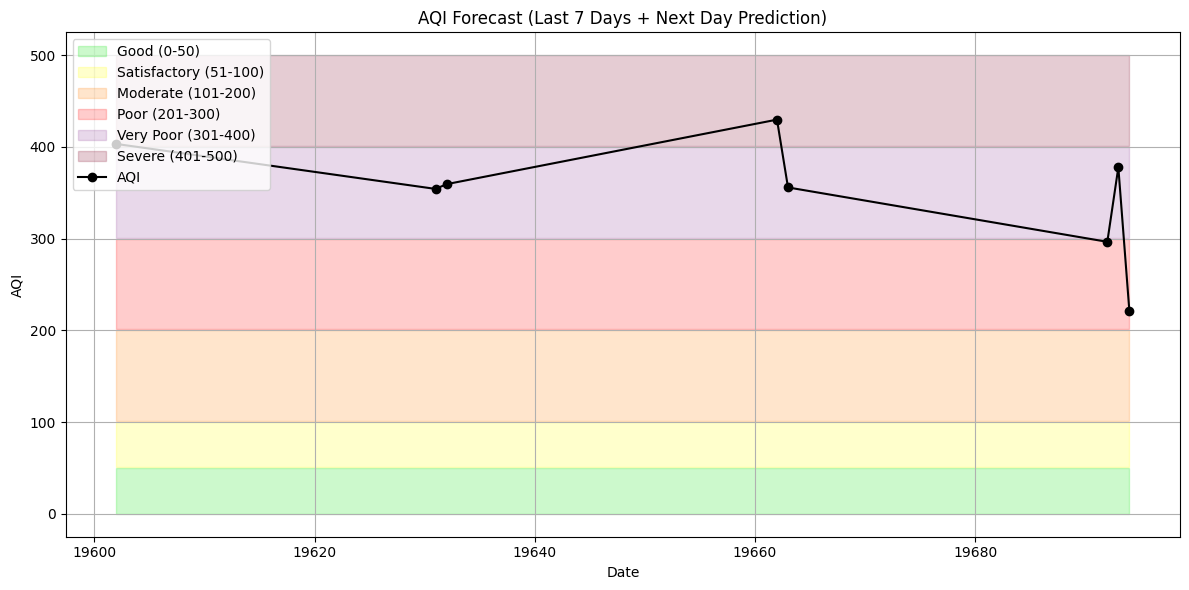

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# === 1. Load and Clean Data ===
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df = df.rename(columns={"from_date": "timestamp", "ozone": "o3", "pm2.5": "pm25"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
    df = df[["timestamp", "pm25", "pm10", "no2", "o3"]].dropna()
    return df

# === 2. AQI Breakpoints ===
BREAKPOINTS = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
             (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 530, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 800, 401, 500)]
}

def calculate_sub_index(pollutant, value):
    for low, high, index_low, index_high in BREAKPOINTS.get(pollutant, []):
        if low <= value <= high:
            return ((index_high - index_low) / (high - low)) * (value - low) + index_low
    return None

def compute_aqi(pm25, pm10, no2, o3):
    sub_indices = [
        calculate_sub_index("pm25", pm25),
        calculate_sub_index("pm10", pm10),
        calculate_sub_index("no2", no2),
        calculate_sub_index("o3", o3),
    ]
    return round(max(filter(None, sub_indices)), 2)

# === 3. Forecast Next-Day Pollutant Values ===
def forecast_next_day_pollutants(df_daily):
    forecast_values = {}
    for pollutant in ["pm25", "pm10", "no2", "o3"]:
        df_temp = df_daily[[pollutant]].reset_index()
        df_temp["day"] = np.arange(len(df_temp))
        model = LinearRegression()
        model.fit(df_temp[["day"]], df_temp[pollutant])
        next_day = np.array([[len(df_temp)]])
        pred = model.predict(next_day)[0]
        forecast_values[pollutant] = round(pred, 2)
    forecast_values["date"] = df_daily.index[-1] + timedelta(days=1)
    forecast_values["aqi"] = compute_aqi(
        forecast_values["pm25"],
        forecast_values["pm10"],
        forecast_values["no2"],
        forecast_values["o3"]
    )
    return forecast_values

# === 4. Main Function with Plot ===
def main():
    file_path = "BandraKurlaComplexMumbaiIITM.csv"
    df = load_and_clean_data(file_path)
    df_daily = df.set_index("timestamp").resample("D").mean().dropna()

    forecast = forecast_next_day_pollutants(df_daily)
    print("\n📈 Forecasted Pollutants and AQI for Next Day:")
    print(f"Date: {forecast['date'].date()}")
    print(f"PM2.5: {forecast['pm25']}, PM10: {forecast['pm10']}, NO2: {forecast['no2']}, O3: {forecast['o3']}")
    print(f"Predicted AQI: {forecast['aqi']}")

    # === Plotting last 7 days + next day forecast ===
    last_actual = df_daily["pm25"].iloc[-7:]
    forecast_day = pd.Series([forecast["pm25"]], index=[forecast["date"]])

    full_series = pd.concat([last_actual, forecast_day])
    aqi_series = [compute_aqi(row["pm25"], row["pm10"], row["no2"], row["o3"]) for _, row in df_daily.iloc[-7:].iterrows()]
    aqi_series.append(forecast["aqi"])
    dates = list(df_daily.index[-7:]) + [forecast["date"]]

    # Plot AQI with color bands
    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    aqi_categories = [
        ("Good", 0, 50, "#00e400"),
        ("Satisfactory", 51, 100, "#ffff00"),
        ("Moderate", 101, 200, "#ff7e00"),
        ("Poor", 201, 300, "#ff0000"),
        ("Very Poor", 301, 400, "#8f3f97"),
        ("Severe", 401, 500, "#7e0023"),
    ]

    for label, low, high, color in aqi_categories:
        ax.add_patch(Rectangle(
            (dates[0], low),
            dates[-1] - dates[0],
            high - low,
            color=color, alpha=0.2,
            label=f"{label} ({low}-{high})"
        ))

    plt.plot(dates, aqi_series, label="AQI", marker='o', color='black')
    plt.title("AQI Forecast (Last 7 Days + Next Day Prediction)")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

# === Run Script ===
if __name__ == "__main__":
    main()


In [4]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import folium
from folium.plugins import HeatMap

# === 1. Setup location mapping (name → lat/lon) ===
LOCATION_COORDINATES = {
    "BKC": (119.0688, 72.8703),
    "BandraMPCB": (19.0418, 772.8653),
    "BoriValiEastIITM": (19.228825, 72.854118),
    "BoriValiEastMPCB": (19.2298,  72.8609),
    "AndheriEast": (19.1179, 72.8631)
}

# === 2. Load and Clean Data ===
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df = df.rename(columns={"from_date": "timestamp", "ozone": "o3", "pm2.5": "pm25"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
    df = df[["timestamp", "pm25", "pm10", "no2", "o3"]].dropna()
    return df

# === 3. AQI Breakpoints ===
BREAKPOINTS = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
             (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 530, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 800, 401, 500)]
}

def calculate_sub_index(pollutant, value):
    for low, high, index_low, index_high in BREAKPOINTS.get(pollutant, []):
        if low <= value <= high:
            return ((index_high - index_low) / (high - low)) * (value - low) + index_low
    return None

def compute_aqi(pm25, pm10, no2, o3):
    sub_indices = [
        calculate_sub_index("pm25", pm25),
        calculate_sub_index("pm10", pm10),
        calculate_sub_index("no2", no2),
        calculate_sub_index("o3", o3),
    ]
    return round(max(filter(None, sub_indices)), 2)

# === 4. Forecast Pollutants for Next Day ===
def forecast_pollutants(df_daily):
    forecast_values = {}
    for pollutant in ["pm25", "pm10", "no2", "o3"]:
        df_temp = df_daily[[pollutant]].reset_index()
        df_temp["day"] = np.arange(len(df_temp))
        model = LinearRegression()
        model.fit(df_temp[["day"]], df_temp[pollutant])
        next_day = np.array([[len(df_temp)]])
        pred = model.predict(next_day)[0]
        forecast_values[pollutant] = round(pred, 2)
    forecast_values["aqi"] = compute_aqi(
        forecast_values["pm25"],
        forecast_values["pm10"],
        forecast_values["no2"],
        forecast_values["o3"]
    )
    return forecast_values

# === 5. Process All Locations ===
def process_all_locations(file_dict):
    results = []
    for location, filepath in file_dict.items():
        df = load_and_clean_data(filepath)
        df_daily = df.set_index("timestamp").resample("D").mean().dropna()
        forecast = forecast_pollutants(df_daily)
        forecast["location"] = location
        forecast["lat"], forecast["lon"] = LOCATION_COORDINATES[location]
        results.append(forecast)
    return pd.DataFrame(results)

# === 6. Plot Heatmap ===
def plot_heatmap(df):
    mumbai_center = [19.0760, 72.8777]
    fmap = folium.Map(location=mumbai_center, zoom_start=11)

    for _, row in df.iterrows():
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=10,
            color=None,
            fill=True,
            fill_opacity=0.7,
            fill_color=get_aqi_color(row["aqi"]),
            popup=f"{row['location']}: AQI {row['aqi']}"
        ).add_to(fmap)

    HeatMap(data=df[["lat", "lon", "aqi"]].values, radius=20).add_to(fmap)
    fmap.save("mumbai_aqi_heatmap.html")
    print("🗺️ Heatmap saved as 'mumbai_aqi_heatmap.html'")

def get_aqi_color(aqi):
    if aqi <= 50:
        return "#00e400"
    elif aqi <= 100:
        return "#ffff00"
    elif aqi <= 200:
        return "#ff7e00"
    elif aqi <= 300:
        return "#ff0000"
    elif aqi <= 400:
        return "#8f3f97"
    else:
        return "#7e0023"

# === 7. Main Execution ===
def main():
    files = {
        "BKC": "BandraKurlaComplexMumbaiIITM.csv",
        "BandraMPCB": "BandraMumbaiMPCB.csv",
        "BoriValiEastIITM": "BorivaliEastMumbaiIITM.csv",
        "BoriValiEastMPCB": "BorivaliEastMumbaiMPCB.csv",
        "AndheriEast": "ChakalaAndheriEastMumbaiIITM.csv"
    }

    results_df = process_all_locations(files)

    print("\n📊 Next-Day AQI Forecast by Location:")
    print(results_df[["location", "pm25", "pm10", "no2", "o3", "aqi"]])

    plot_heatmap(results_df)

# === Run Script ===
if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/


📊 Next-Day AQI Forecast by Location:
           location   pm25    pm10     no2     o3     aqi
0               BKC  97.01  159.19  117.78  28.29  221.52
1        BandraMPCB  42.26  111.22   16.50  72.71  107.79
2  BoriValiEastIITM  53.75  146.69   39.04  30.91  131.36
3  BoriValiEastMPCB  48.60   89.77   10.26  34.71   89.77
4       AndheriEast  74.73  114.66   74.38  37.50  147.87
🗺️ Heatmap saved as 'mumbai_aqi_heatmap.html'


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
